# 1. Setup

In [1]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

In [2]:
import os
import pathlib
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook

# Custom utils for rasterio
from src.data_loading.rasterio_utils import get_thumbnail, read_from_lat_lon
from src.data_loading.vector_utils import shapely_to_frame
from src.data_loading.landcover_plot_utils import classes_to_rgb
from src.utils import get_byte_size, get_osm_polygon

# Path to ESA Landcover datasets on Jasmin
from src.constants import ESA_LANDCOVER_DIR, GWS_DATA_DIR, WGS84, PREFERRED_CRS

# For loading geotiff data
import rasterio
from rasterio.mask import mask
from rasterio.crs import CRS

# For loading and manipulating vector data
import geopandas as gpd
from shapely.geometry import box, Point
# For performing geospatial analysis
import pylandstats as pls

# For conveniently getting longitude, latitude from name (& geodesic distances)
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="fragmentation-analysis")
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 2. Data loading

## 2.1 Chernobyl geographic data

Let us first load the location of the Chernobyl nuclear power plant, as well as the borders
of the exclusion zones in Chernobyl (Ukraine) and Polesie (Belarus) from Open Street map.

Note that the Open Street map coordinate system is WGS84, while we will later work in UTM 35,
to be able to locally express distances in meters.

In [3]:
nuclear_plant = geolocator.geocode("Chernobyl Nuclear Plant")
nuclear_plant = Point((nuclear_plant.longitude, nuclear_plant.latitude))

# Get exclusion zone boundaries for chernobyl (Ukraine)
chernobyl_zone_id = 3311547
chernobyl_exclusion_zone = gpd.read_file(get_osm_polygon(chernobyl_zone_id))  # in WGS 84
chernobyl_exclusion_zone.crs = WGS84  # set coorindate system to WGS 84
chernobyl_exclusion_zone["name"] = ["Chernobyl Exclusion Zone"]

# Get exclusion zone boundaries for polesie (Belarus)
polesie_zone_id = 3397849
polesie_exclusion_zone = gpd.read_file(get_osm_polygon(polesie_zone_id))  # in WGS 84
polesie_exclusion_zone.crs = WGS84  # set coorindate system to WGS 84
polesie_exclusion_zone["name"] = ["Polesie Exclusion Zone"]
# NOTE: 
# Potentially we want to create our own CRS with the power plant / exclusion zone 
#  centroid at its center, such that we can measure distances conveniently in meters
#  on the ground.

## 2.2 ESA CCI landcover data

We are using ESA CCI Landcover data from 1992 to 2015 with a ground resolution (GSD) of 
300m.

In [4]:
esa_cci_landcovers = {year: ESA_LANDCOVER_DIR / f"ESACCI-LC-L4-LCCS-Map-300m-P1Y-{year}-v2.0.7.tif" 
                      for year in range(1992, 2016)}

# Check that paths indeed exist
for path in esa_cci_landcovers.values():
    assert os.path.exists(path)
    
# Parse land cover classes:
landcover_classes = ESA_LANDCOVER_DIR / "ESACCI-LC-Legend.csv"
classes = pd.read_csv(landcover_classes, delimiter=";", index_col=0)

print(f"There are {len(classes)} classes.")
print(classes.head())

There are 38 classes.
                                 LCCOwnLabel    R    G    B
NB_LAB                                                     
0                                    No data    0    0    0
10                         Cropland, rainfed  255  255  100
11                          Herbaceous cover  255  255  100
12                       Tree or shrub cover  255  255    0
20      Cropland, irrigated or post-flooding  170  240  240


The ESA CCI dataset has 37 classes of landcover (+ 1 no data class). 

# 3. Experimental setup

In [5]:
## TO FILE:
from shapely.geometry.base import BaseGeometry
from typing import Union, List, Tuple, Iterable, Dict, Any

def shapely_to_frame(shapes: Union[BaseGeometry, Union[BaseGeometry]], 
                     attributes: Dict[str, Any] = {}, 
                     crs: str = None, 
                     **kwargs):       
    """Convenience function to turn shapely objects into geopandas dataframes"""
    
    is_multiple = isinstance(shapes, Iterable)
        
    data = {"geometry": shapes if is_multiple else [shapes]}
    for key, val in attributes.items():
        data[key] = val if is_multiple else [val]
        
    for key, val in kwargs.items():
        data[key] = val if is_multiple else [val]
    
    return gpd.GeoDataFrame(data, crs=crs)

## 3.1 Define regions of interest

Define regions of interest for later comparisons in the study:

1. Combination of the exlcusion zones (representing no human impact).
2. 30 km buffer around the exclusion zones (representing reduced human impact)
3. 60 km buffer around the exclusion zones (representing mostly normal human impact)

In [6]:
# Next closer ROI: 30km buffer around exclusion zones (reduced human activity)
buffer_size = 30 # in km (preferred CRS: UTM 35 is in m)

# Generate ROIs from exclusion zones: 
roi0 = shapely_to_frame(nuclear_plant, crs=WGS84, name="Nuclear Plant")
roi1 = chernobyl_exclusion_zone.append(polesie_exclusion_zone)

# Generate (exclusion_zone + buffer) and (exclusion_zone + 2*buffer) ROIs
roi3_outline = roi1.to_crs(PREFERRED_CRS).buffer(2*buffer_size*1e3).to_crs(WGS84).unary_union
roi2_outline = roi1.to_crs(PREFERRED_CRS).buffer(buffer_size*1e3).to_crs(WGS84).unary_union

roi3_shape = roi3_outline - roi2_outline
roi2_shape = roi2_outline - roi1.unary_union

roi3 = shapely_to_frame(roi3_shape, crs=WGS84, name=f"E+{2*buffer_size}")
roi2 = shapely_to_frame(roi2_shape, crs=WGS84, name=f"E+{buffer_size}")

# Get bounding box of all ROIs
bbox = shapely_to_frame(roi3_shape.envelope, crs=WGS84, name="bbox")

Let's add the regions of interest to one single data frame and caluclate their areas in km$^2$

In [7]:
# Calculate the areas
rois = bbox.append([roi3, roi2, roi1, roi0]).reset_index(drop=True)
rois["area (km2)"] = rois.to_crs(PREFERRED_CRS).area / 1e6
rois

,geometry,name,area (km2)
0,"POLYGON ((28.40773 50.54449, 31.41977 50.54449...",bbox,44022.318370
1,"POLYGON ((28.42221 51.16929, 28.42178 51.17077...",E+60,17608.538086
2,"POLYGON ((28.84467 51.21708, 28.84425 51.21856...",E+30,12731.935189
3,GEOMETRYCOLLECTION (MULTIPOLYGON (((29.26795 5...,Chernobyl Exclusion Zone,2597.858793
4,GEOMETRYCOLLECTION (MULTIPOLYGON (((29.46530 5...,Polesie Exclusion Zone,2216.675202
5,POINT (30.10410 51.38974),Nuclear Plant,0.000000


Note: The area in km2 for the Chernobyl exclusion zone matches with the quoted value on Wikipedia,
which is approx [2600 km2](https://en.wikipedia.org/wiki/Chernobyl_Exclusion_Zone).

In [8]:
get_byte_size(rois)

'14 KB'

Next, let's visualise our areas of interest on the map (WGS84 coordinates - latitude, longitude)

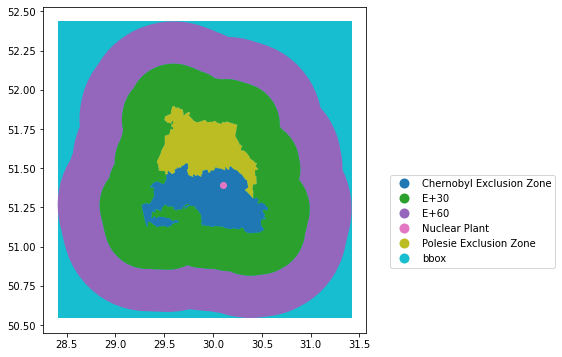

In [9]:
fig, ax = plt.subplots(figsize=(14, 6))

rois.to_crs(WGS84).plot(column="name", categorical=True, legend=True, ax=ax)
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.6,0.5))

In [11]:
rois.to_file(GWS_DATA_DIR / "chernobyl_exclusion_zone_v1.geojson", driver='GeoJSON')

## 3.2 Cut landcover datasets to regions of interest

Next, let us look at the region of the landcover data that we cut out for the 
sample case of 2015

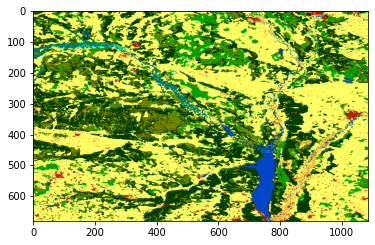

In [10]:
landcover_2015 = rasterio.open(esa_cci_landcovers[2015])

minx, miny, maxx, maxy = bbox.bounds.iloc[0].values
lat = (miny, maxy)
lon = (minx, maxx)

plt.imshow(classes_to_rgb(read_from_lat_lon(landcover_2015, 1, lat, lon)));

Ok, from a quick comparison to the map on OSM, this seems correct.

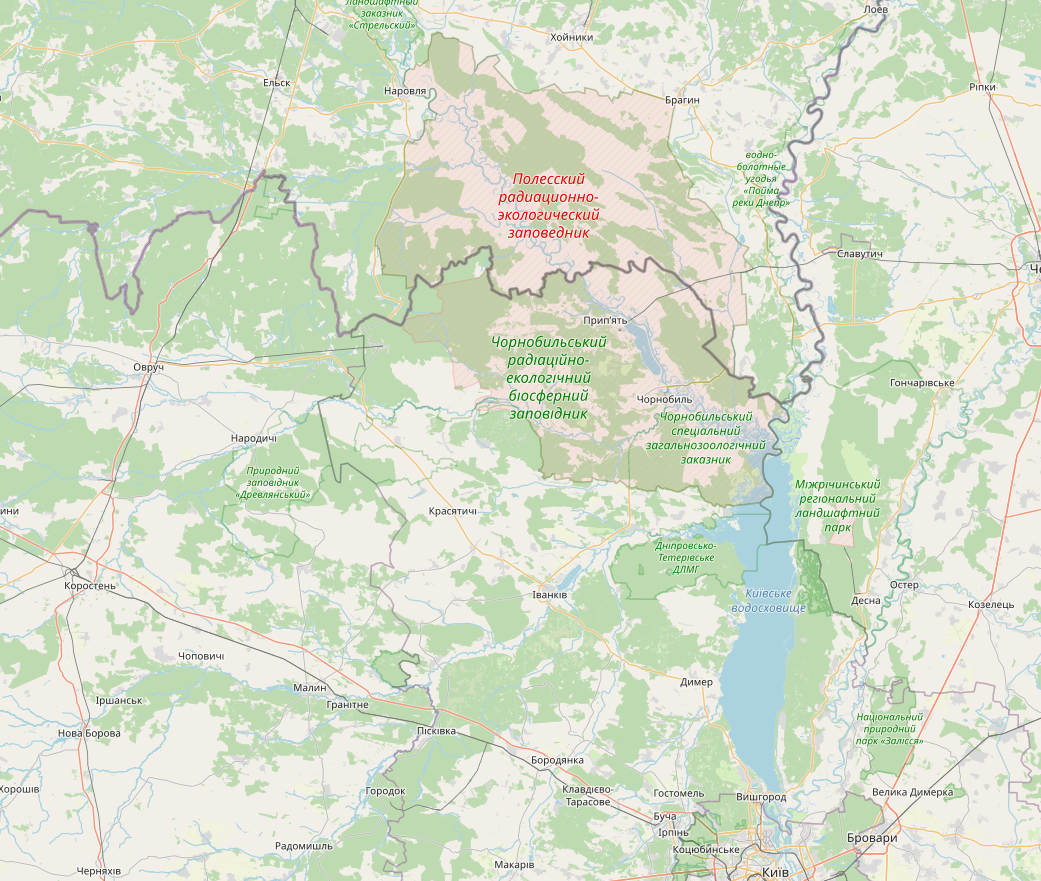

Now the next step is to cut out the bounding box of our interest from the landcover datasets
for the years 1992 to 2015.

In [13]:
bbox_landcovers = {}

for year, data_path in tqdm.notebook.tqdm(esa_cci_landcovers.items()):
    logging.info(f"Processing year {year}")
    
    # Crop to bbox around regions of interest
    with rasterio.open(data_path, "r") as data:
        out_img, out_transform = mask(data, shapes=bbox.geometry, crop=True)
        out_meta = data.meta.copy()
    
    # Update metadata for cropped region
    out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": CRS.from_string(WGS84)})
    
    # Write clipping to disk
    out_tif = GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_{year}_chernobyl.geojson"
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)
        
    bbox_landcovers[year] = (out_img, out_transform)

  0%|          | 0/24 [00:00<?, ?it/s]

INFO: Processing year 1992
INFO: Processing year 1993
INFO: Processing year 1994
INFO: Processing year 1995
INFO: Processing year 1996
INFO: Processing year 1997
INFO: Processing year 1998
INFO: Processing year 1999
INFO: Processing year 2000
INFO: Processing year 2001
INFO: Processing year 2002
INFO: Processing year 2003
INFO: Processing year 2004
INFO: Processing year 2005
INFO: Processing year 2006
INFO: Processing year 2007
INFO: Processing year 2008
INFO: Processing year 2009
INFO: Processing year 2010
INFO: Processing year 2011
INFO: Processing year 2012
INFO: Processing year 2013
INFO: Processing year 2014
INFO: Processing year 2015


In [399]:
get_byte_size(bbox_landcovers)

'16 MB'

We see that only the light-weight handle to the file is loaded, not the content of the file

# 4. Calculating Fragmentation statistics